In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Load the cleaned dataset
data = pd.read_csv('FinalApartments_data.csv')

In [20]:
# Identifying numerical and categorical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove non-relevant columns
numerical_features = [col for col in numerical_features if col not in ['id', 'time']]
categorical_features = ['has_photo', 'pets_allowed', 'price_type', 'state']

print("Numerical Features:", numerical_features)
print("\nCategorical Features:", categorical_features)

Numerical Features: ['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'longitude']

Categorical Features: ['has_photo', 'pets_allowed', 'price_type', 'state']


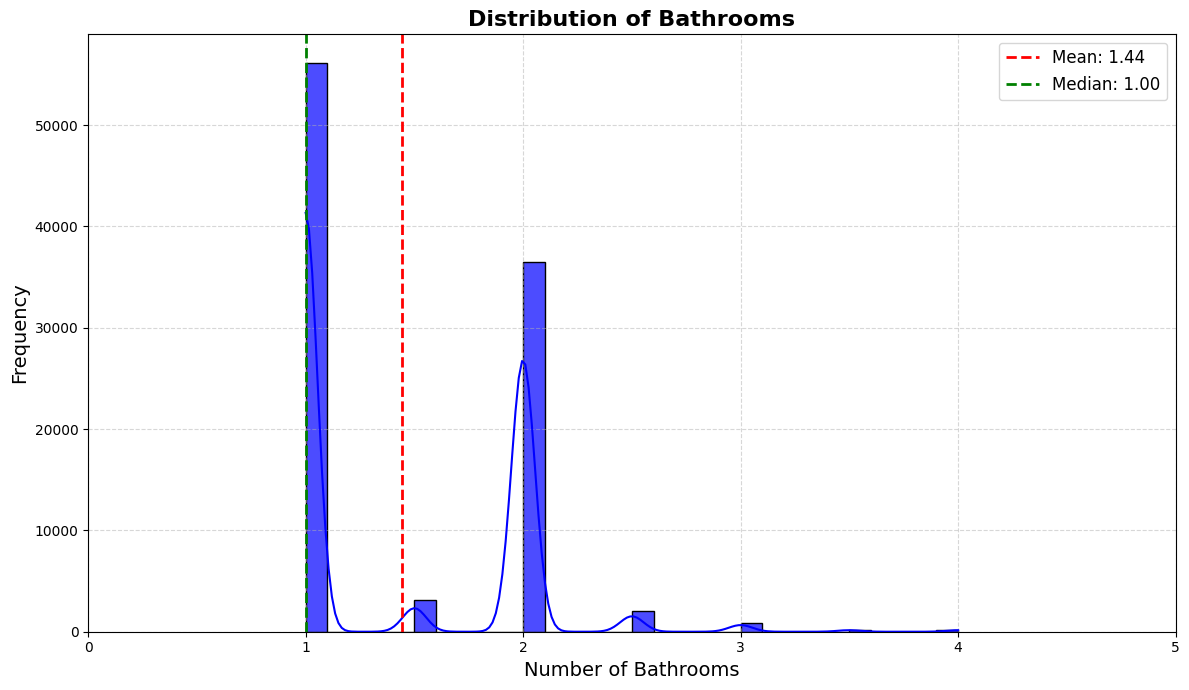

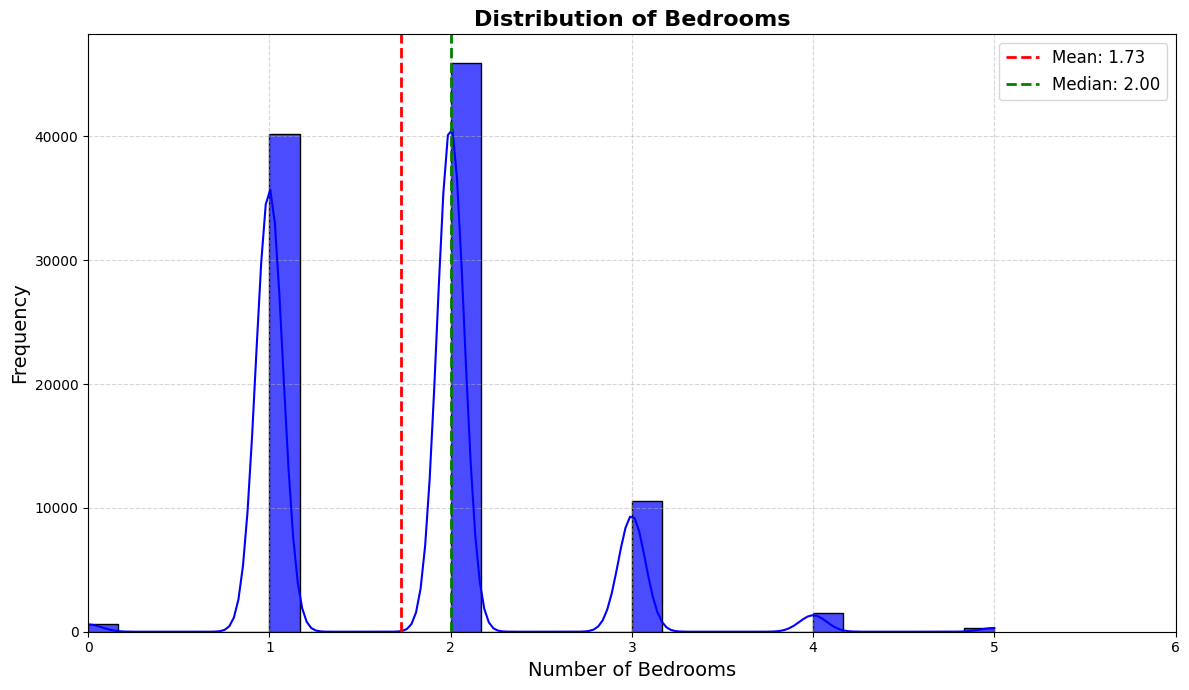

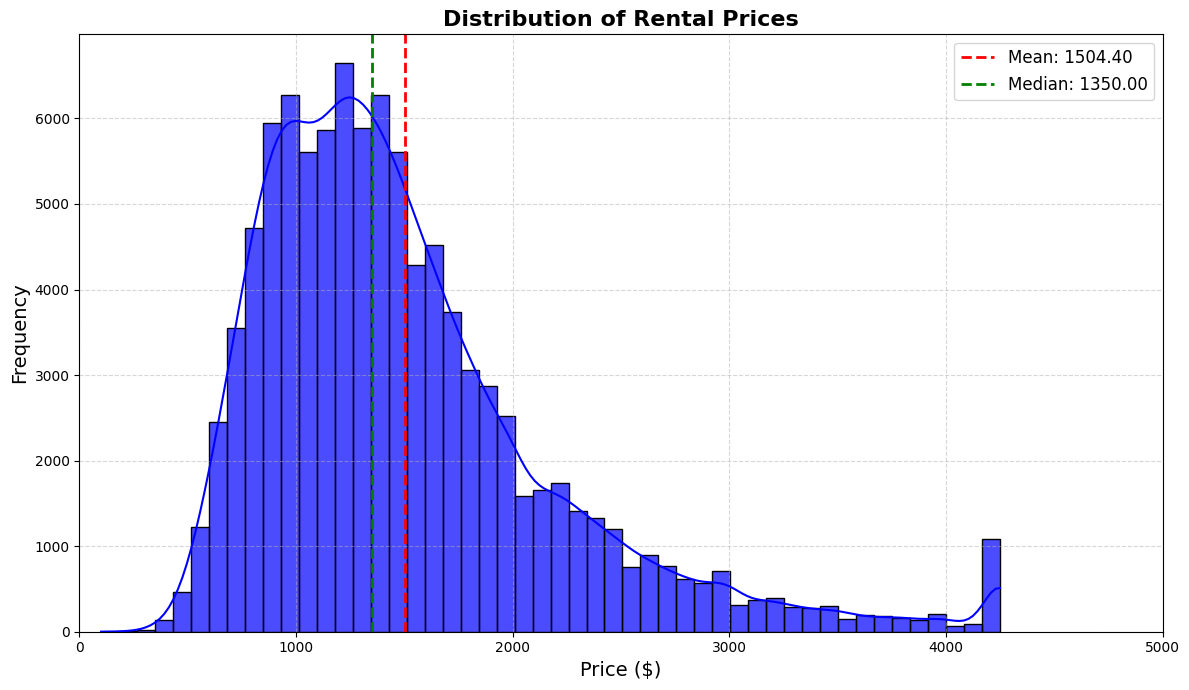

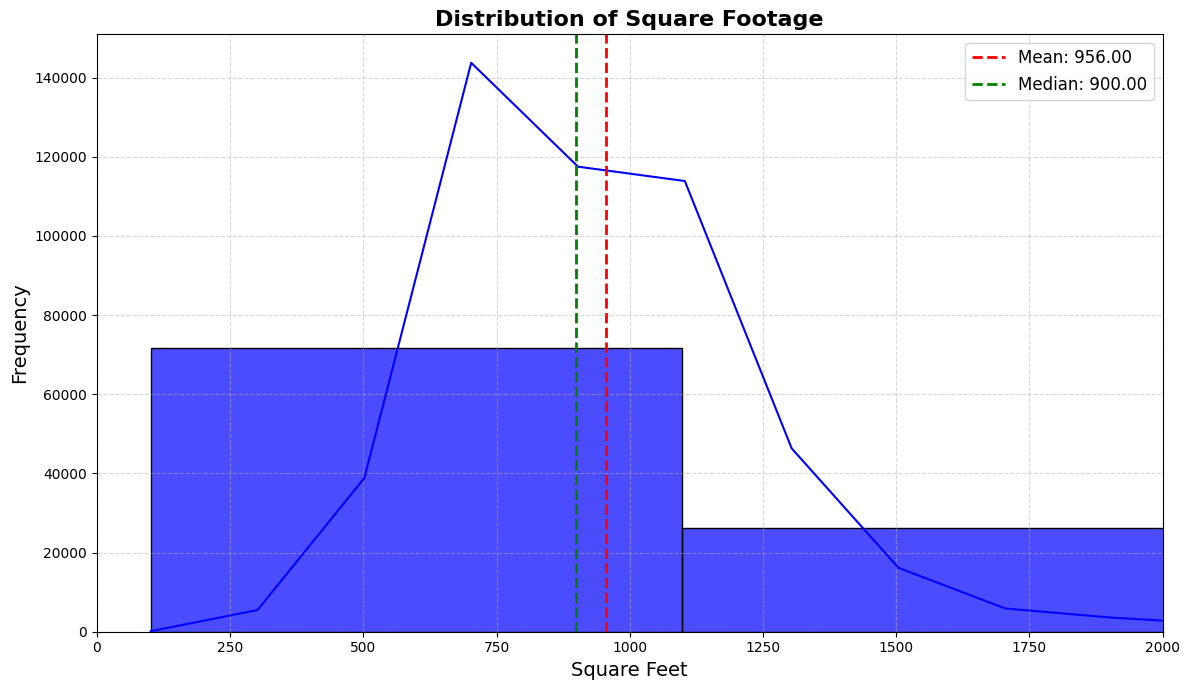

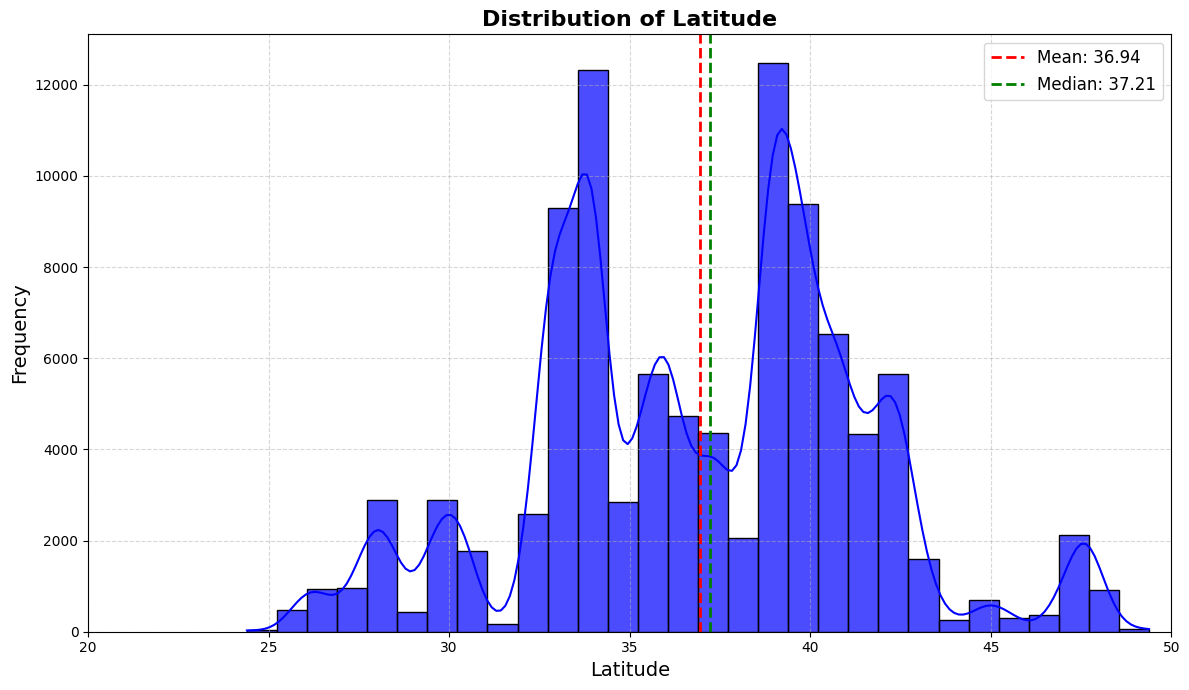

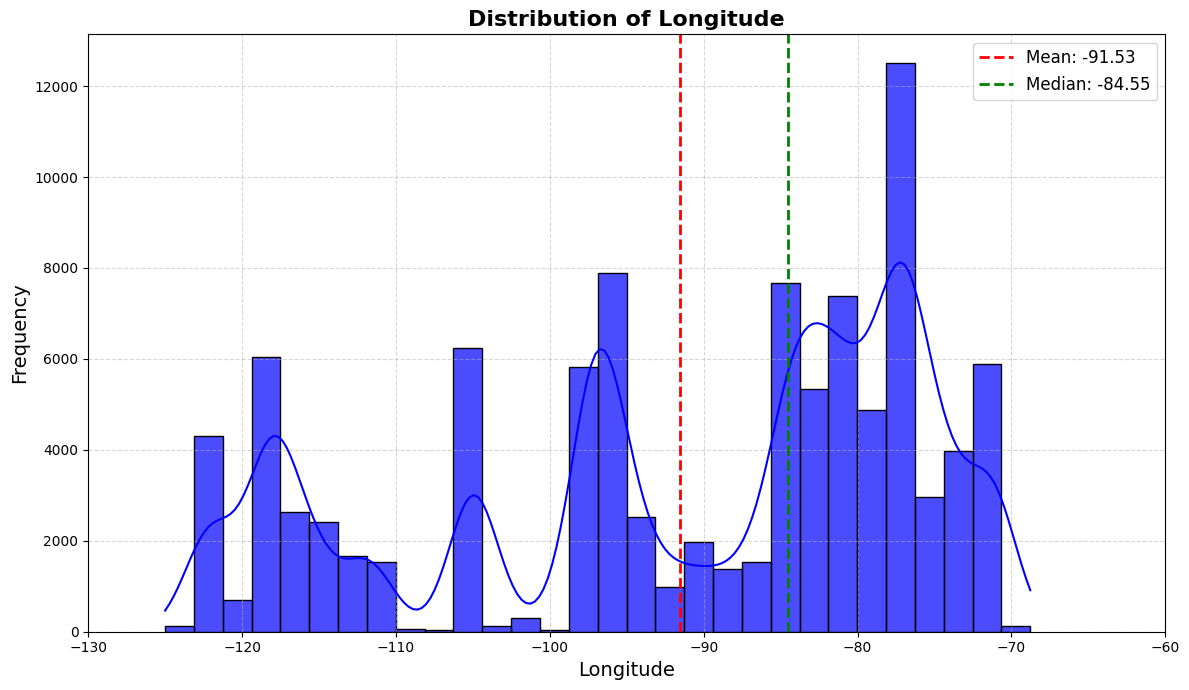

In [21]:
# Numerical Feature Distributions visualization
feature_settings = {
    'bathrooms': {
        'bins': 30,
        'xlim': (0, 5),
        'xlabel': 'Number of Bathrooms',
        'title': 'Distribution of Bathrooms'
    },
    'bedrooms': {
        'bins': 30,
        'xlim': (0, 6),
        'xlabel': 'Number of Bedrooms',
        'title': 'Distribution of Bedrooms'
    },
    'price': {
        'bins': 50,
        'xlim': (0, 5000),
        'xlabel': 'Price ($)',
        'title': 'Distribution of Rental Prices'
    },
    'square_feet': {
        'bins': 40,
        'xlim': (0, 2000),
        'xlabel': 'Square Feet',
        'title': 'Distribution of Square Footage'
    },
    'latitude': {
        'bins': 30,
        'xlim': (20, 50),
        'xlabel': 'Latitude',
        'title': 'Distribution of Latitude'
    },
    'longitude': {
        'bins': 30,
        'xlim': (-130, -60),
        'xlabel': 'Longitude',
        'title': 'Distribution of Longitude'
    }
}

# visualization for each feature
for feature in numerical_features:
    settings = feature_settings[feature]
    
    plt.figure(figsize=(12, 7))
    
    # Create histogram with KDE
    sns.histplot(data[feature], 
                 bins=settings['bins'],
                 kde=True,
                 color='blue',
                 edgecolor='black',
                 alpha=0.7)
    
    # Customize the plot
    plt.title(settings['title'], fontsize=16, fontweight='bold')
    plt.xlabel(settings['xlabel'], fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(settings['xlim'])
    
    # Add mean and median lines
    mean_val = data[feature].mean()
    median_val = data[feature].median()
    
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='--', linewidth=2,
                label=f'Median: {median_val:.2f}')
    
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(f'project_visualization/Distribution_of_{feature}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

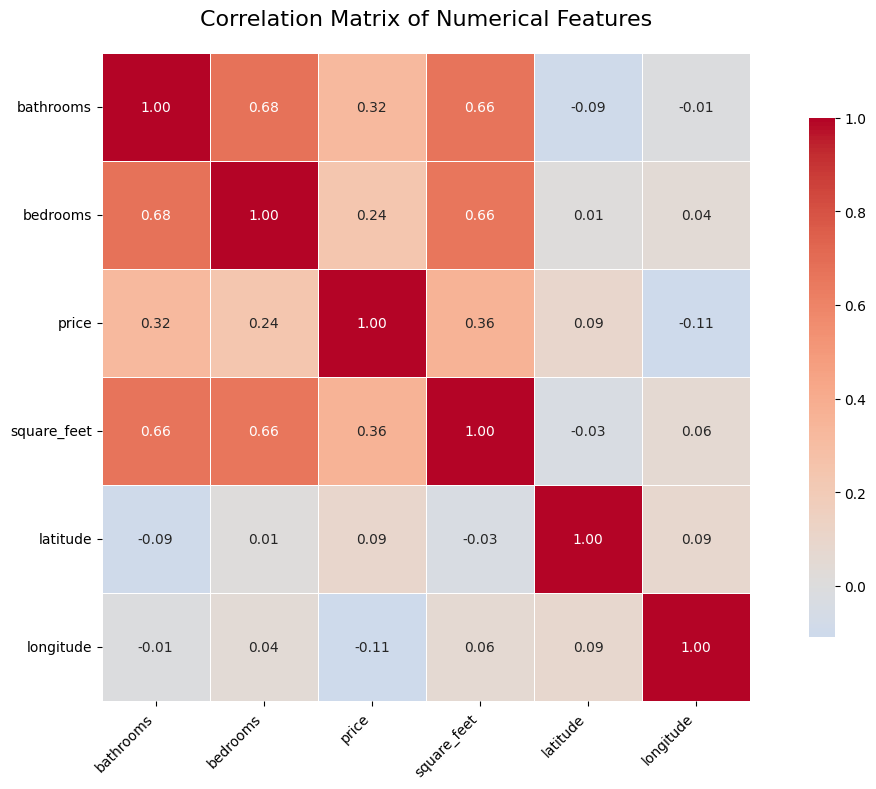

In [22]:
# Correlation between Numerical Variables
correlation_matrix = data[numerical_features].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('project_visualization/Correlation_Matrix_of_Numerical_Features.png')
plt.show()

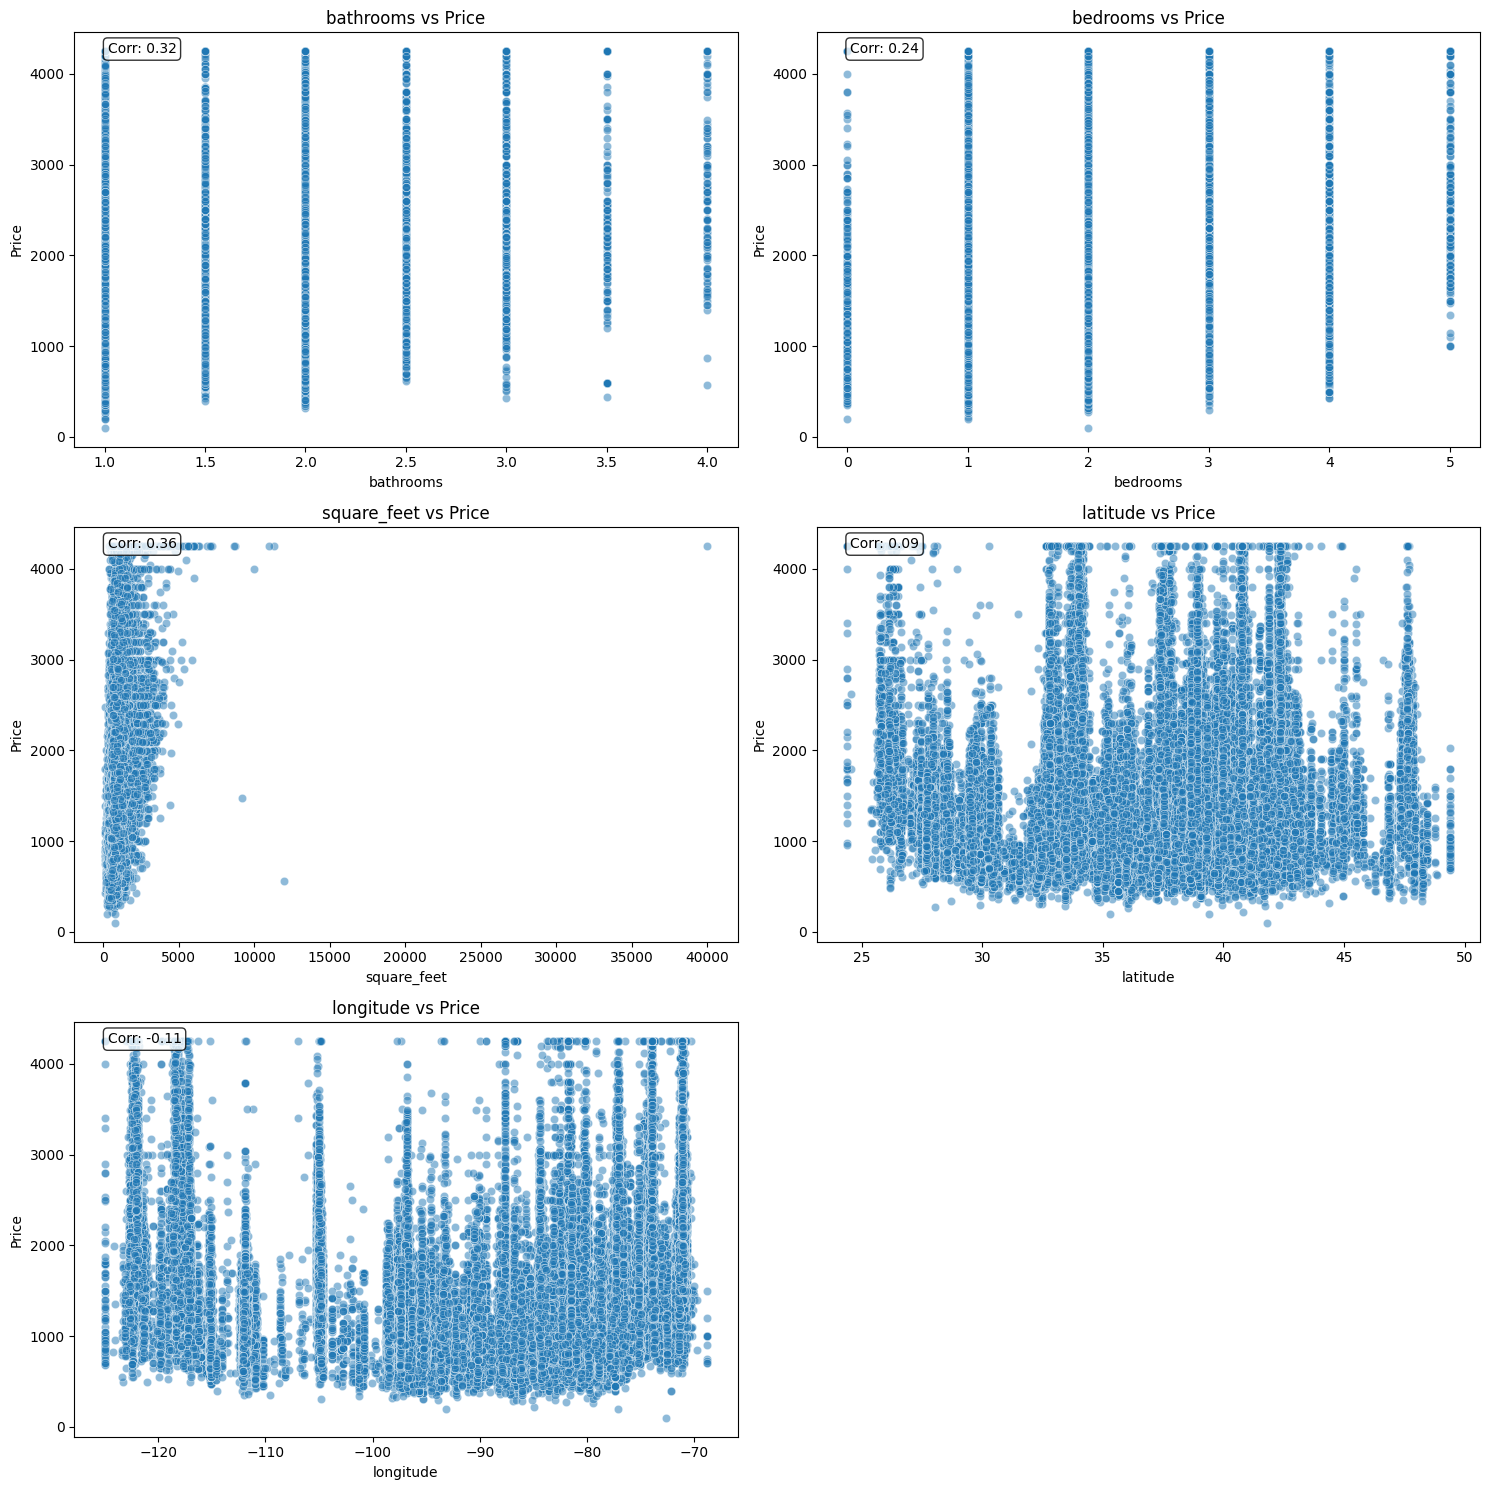

In [23]:
# Scatter plots and Correlation for each numerical feature against price
num_features = [col for col in numerical_features if col != 'price']
n_cols = 2
n_rows = (len(num_features) + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.scatterplot(data=data, x=feature, y='price', ax=axes[i], alpha=0.5)
    axes[i].set_title(f'{feature} vs Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')
    
    corr = data[feature].corr(data['price'])
    axes[i].annotate(f'Corr: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('project_visualization/Scatter_plots_Correlation_for_each_Numerical_Features_againstPrice.png')
plt.show()

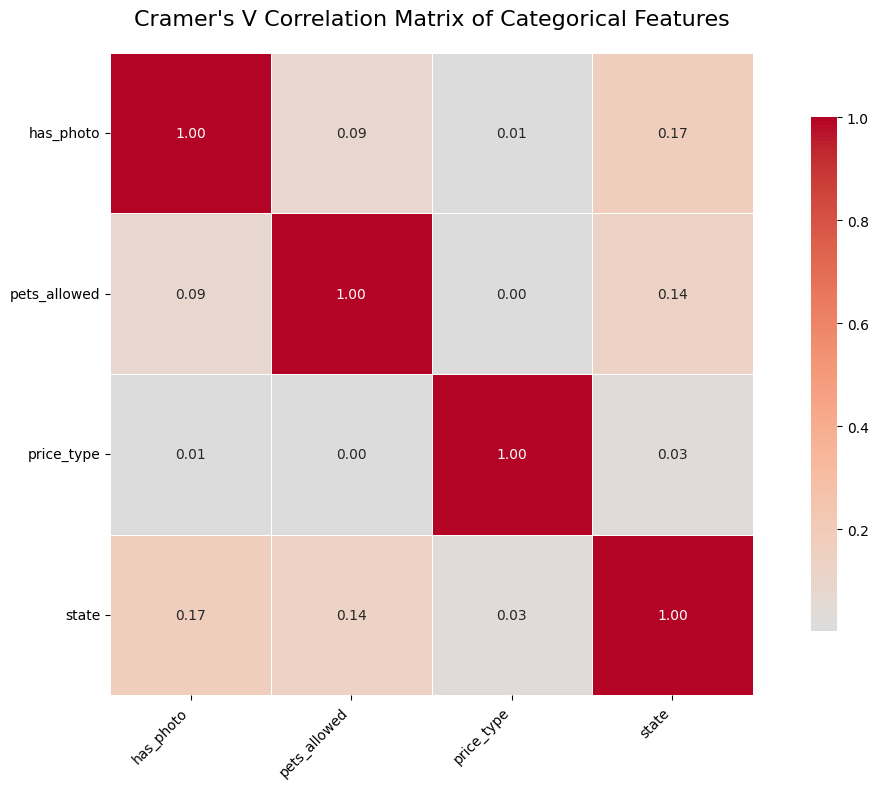

In [24]:
# Correlation between Categorical Variables
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Create correlation matrix for categorical variables
cat_corr_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

for var1 in categorical_features:
    for var2 in categorical_features:
        if var1 != var2:
            confusion_matrix = pd.crosstab(data[var1], data[var2])
            cat_corr_matrix.loc[var1, var2] = cramers_v(confusion_matrix)
        else:
            cat_corr_matrix.loc[var1, var2] = 1.0

cat_corr_matrix = cat_corr_matrix.astype(float)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cat_corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title("Cramer's V Correlation Matrix of Categorical Features", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('project_visualization/Correlation_Matrix_of_Categorical_Features.png')
plt.show()

In [25]:
# categorizing price into High, Low, and Mediun
def categorize_price(price, data):
    # Find quantiles for balanced categories
    q1 = data['price'].quantile(0.33)
    q2 = data['price'].quantile(0.67)
    if price <= q1:
        return 'Low'
    elif price <= q2:
        return 'Medium'
    else:
        return 'High'

# Create price categories
data['price_category'] = data['price'].apply(lambda x: categorize_price(x, data))

# Print distribution of price categories
price_distribution = data['price_category'].value_counts()
print("\nPrice Category Distribution:")
print(price_distribution)
print(f"Low: {price_distribution['Low']/len(data)*100:.2f}% | "
      f"Medium: {price_distribution['Medium']/len(data)*100:.2f}% | "
      f"High: {price_distribution['High']/len(data)*100:.2f}%")


Price Category Distribution:
price_category
Medium    33602
Low       32804
High      32699
Name: count, dtype: int64
Low: 33.10% | Medium: 33.91% | High: 32.99%


In [26]:
# Adding new features
# Bedrooms to bathrooms ratio
data['bed_bath_ratio'] = data.apply(
    lambda row: row['bedrooms'] / max(row['bathrooms'], 0.5), axis=1
)

# square feet per bedroom
data['sqft_per_bedroom'] = data.apply(
    lambda row: row['square_feet'] / max(row['bedrooms'], 1), axis=1
)

# Select relevant numerical and categorical features
numerical_features = [
    'bedrooms', 'bathrooms', 'square_feet', 'latitude', 'longitude',
    'bed_bath_ratio'
]

Generating Box Plots (Numerical vs. Target)


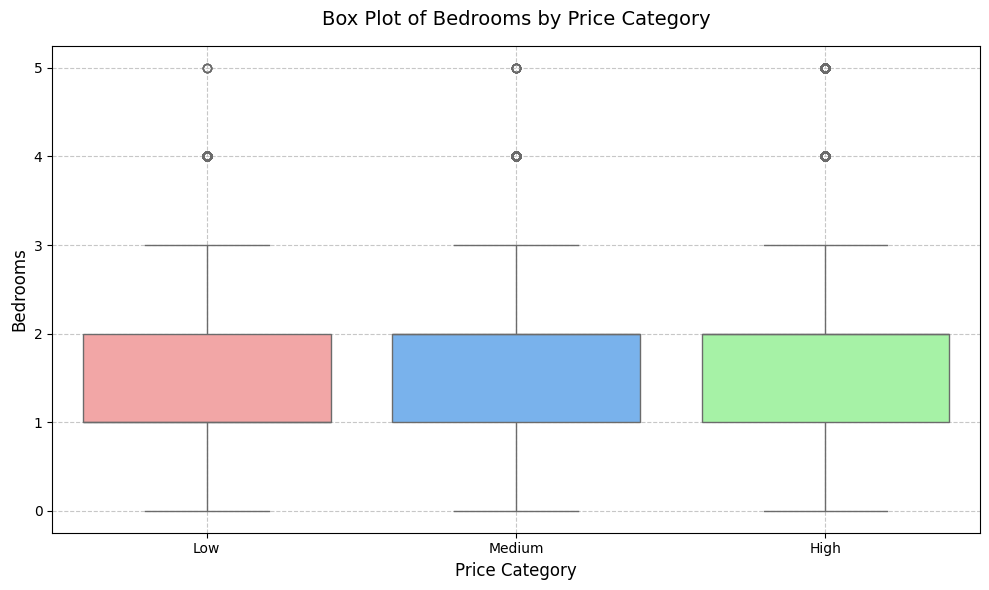

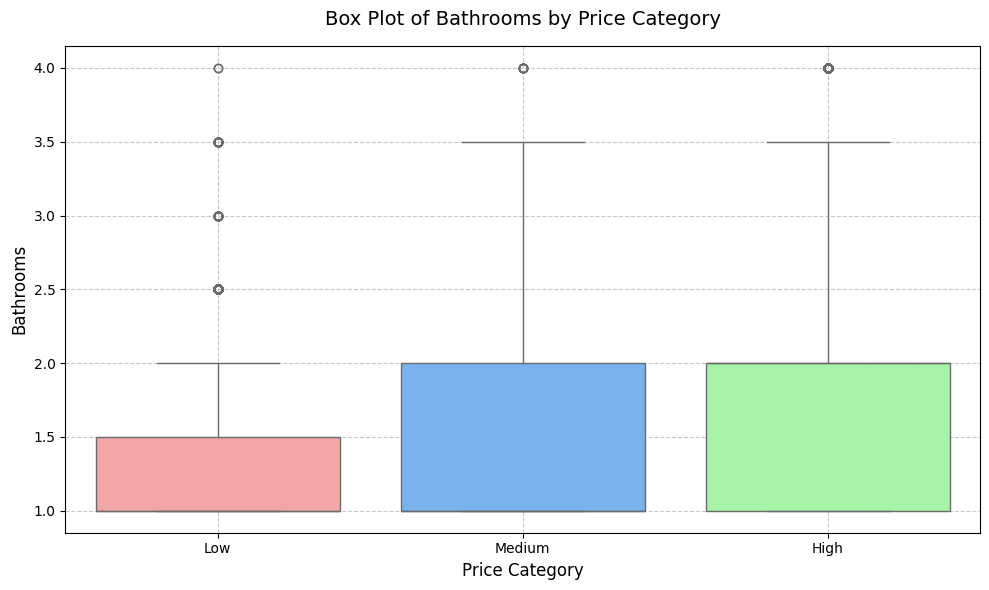

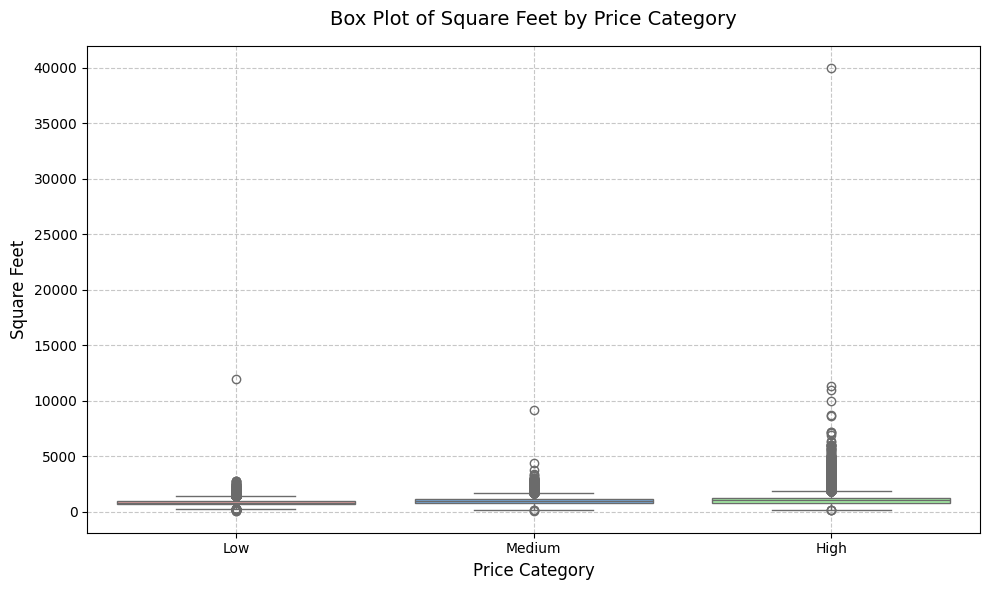

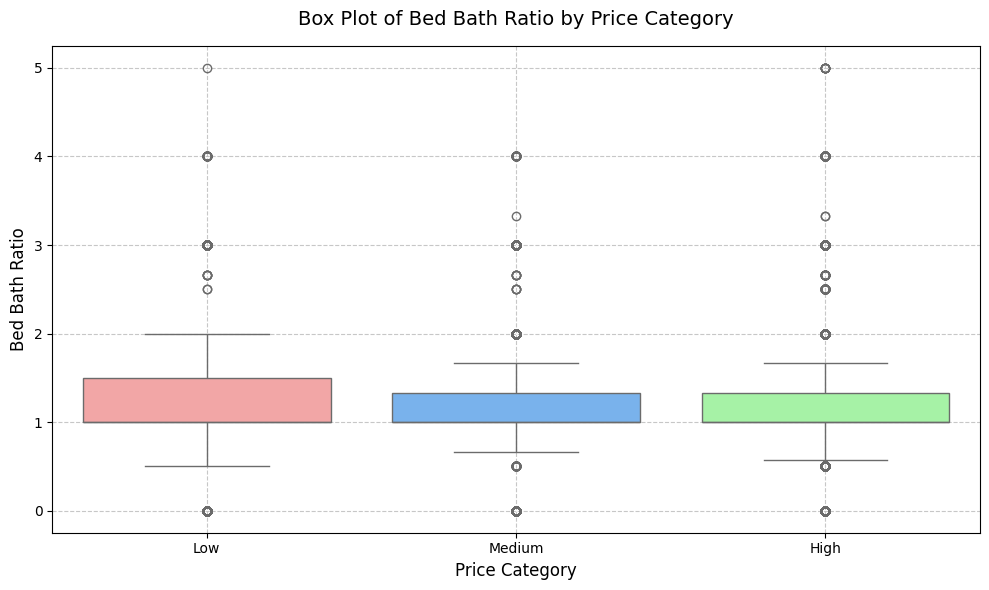

In [27]:
# Box Plots for Numerical Features vs. Target Variable
print("Generating Box Plots (Numerical vs. Target)")

# Define colors for each price category
price_colors = {
    'Low': '#FF9999',    # Light red
    'Medium': '#66B2FF', # Light blue
    'High': '#99FF99'    # Light green
}

for feature in numerical_features:
    if feature not in ['latitude', 'longitude', 'time']:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='price_category', y=feature, data=data, 
                   order=['Low', 'Medium', 'High'],
                   palette=price_colors)
    
        plt.title(f'Box Plot of {feature.replace("_", " ").title()} by Price Category', 
                 fontsize=14, pad=15)
        plt.xlabel('Price Category', fontsize=12)
        plt.ylabel(feature.replace("_", " ").title(), fontsize=12)
        
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f'project_visualization/Box_Plots_of_{feature.replace("_", " ").title()}_by_Price Category.png')
        plt.show()

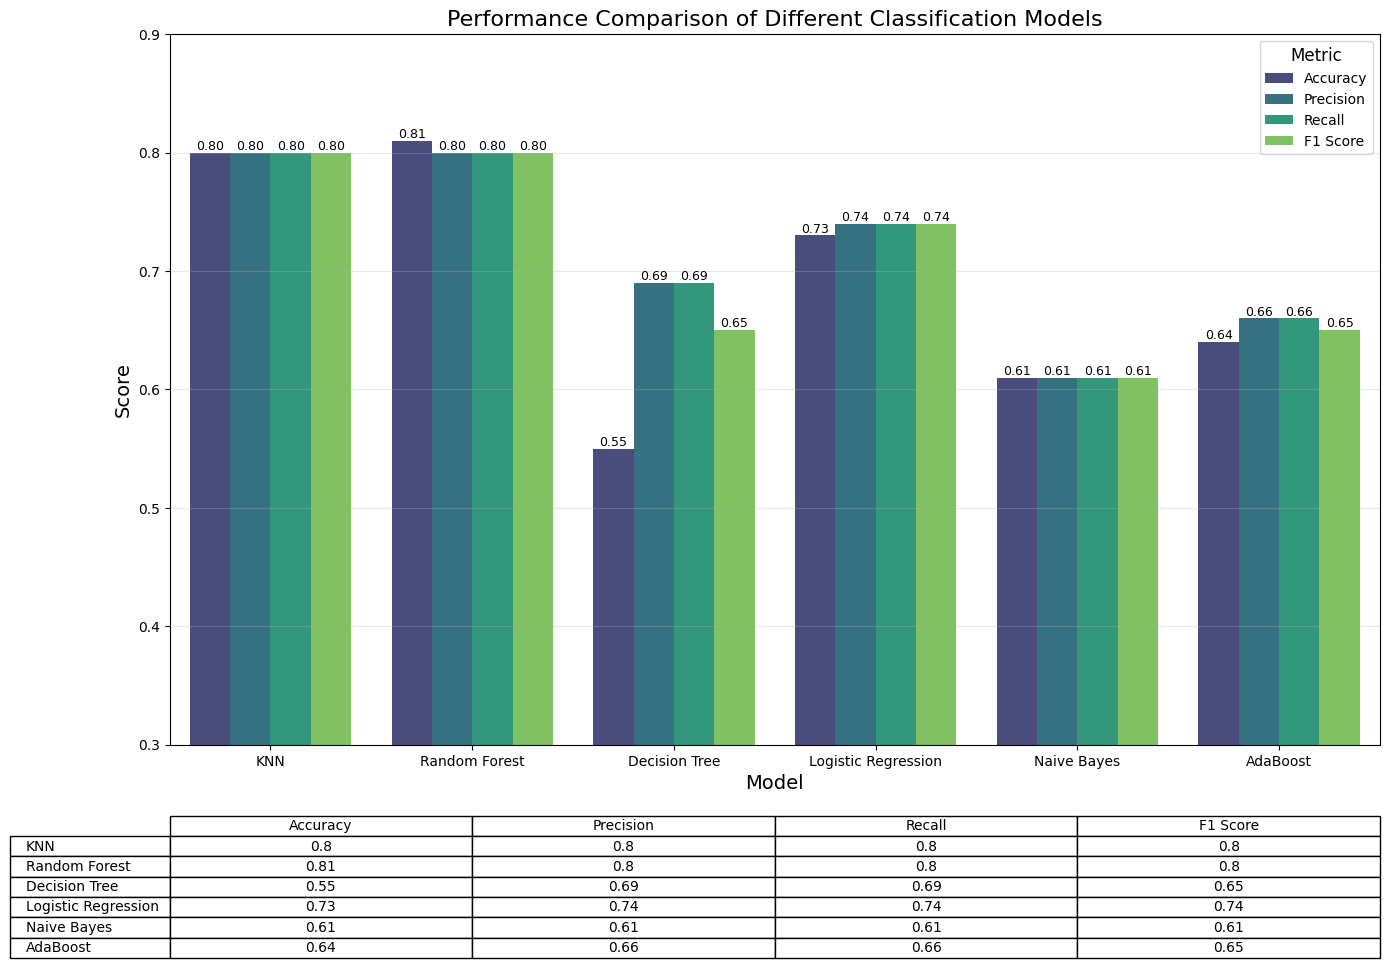

In [29]:
# Final model results
models = ['KNN', 'Random Forest', 'Decision Tree', 'Logistic Regression', 'Naive Bayes', 'AdaBoost']

# model metrics
accuracy = [0.80, 0.81, 0.55, 0.73, 0.61, 0.64]
precision = [0.80, 0.80, 0.69, 0.74, 0.61, 0.66 ]
recall = [0.80, 0.80, 0.69, 0.74, 0.61, 0.66]
f1 = [0.80, 0.80, 0.65, 0.74, 0.61, 0.65]

metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

metrics_long = pd.melt(metrics_df, id_vars=['Model'], 
                     value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                     var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 10))

ax = sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_long, palette='viridis')

plt.title('Performance Comparison of Different Classification Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0.3, 0.9)

plt.grid(axis='y', alpha=0.3)
plt.legend(title='Metric', title_fontsize=12, fontsize=10, loc='upper right')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=9)

table_data = metrics_df.set_index('Model').round(4)
plt.table(cellText=table_data.values,
          rowLabels=table_data.index,
          colLabels=table_data.columns,
          cellLoc='center',
          loc='bottom',
          bbox=[0.0, -0.3, 1.0, 0.2])

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.savefig('project_visualization/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()